### Importing libraries

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import plotly as py
import plotly.express as px
import plotly.graph_objects as go

### Importing dataset

In [84]:
data = yf.download("HDB", period='730d', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [85]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-04,55.849998,56.000000,54.660000,55.220001,54.403439,2907600
2019-10-07,54.930000,55.840000,54.849998,55.810001,54.984715,2183800
2019-10-08,55.639999,55.939999,55.549999,55.930000,55.102936,2535600
2019-10-09,56.799999,57.189999,56.700001,56.779999,55.940369,1312100
2019-10-10,56.330002,56.430000,55.740002,56.419998,55.585690,1713500
...,...,...,...,...,...,...
2022-08-22,61.689999,62.400002,61.669998,62.130001,62.130001,933800
2022-08-23,62.029999,62.669998,61.900002,62.200001,62.200001,812600
2022-08-24,62.340000,63.090000,62.099998,62.849998,62.849998,552400


### Visualising price trend

In [86]:
data["Date"] = data.index
data["10daymovingavg"] =  data["Adj Close"].rolling(10).mean()
fig = px.line(data,x ='Date',y="Adj Close",title= "ICICI BANK")
fig.show()
    

### Visualising candlestick chart

In [87]:
fig = go.Figure(data=[go.Candlestick(x=data['Date'],
                    open=data['Open'],
                    high=data['High'],
                    low=data['Low'],
                    close=data['Close']),

                    go.Scatter(x=data["Date"],y=data["10daymovingavg"])])
    

fig.update_layout(autosize=False,
                     width = 1000,
                     height=700,
                     title = "ICICI BANK")

    

fig.show()

### Technical indicators

In [88]:
data["20daymovingavg"] =  data["Adj Close"].rolling(20).mean()

In [89]:
data["std10"] = data['Adj Close'].rolling(10).std()
data["std20"] = data['Adj Close'].rolling(20).std()

#### RSI indicator

In [90]:
def RSI (data, time_window):
    diff = data.diff(1).dropna()        

    up = 0 * diff
    down = 0 * diff
    
    up[diff > 0] = diff[ diff>0 ]
    
    down[diff < 0] = diff[ diff < 0 ]
    
    up_avg   = up.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_avg = down.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_avg/down_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [91]:
data['rsi5'] = RSI(data['Adj Close'], 5)
data['rsi14'] = RSI(data['Adj Close'], 14)

#### MACD

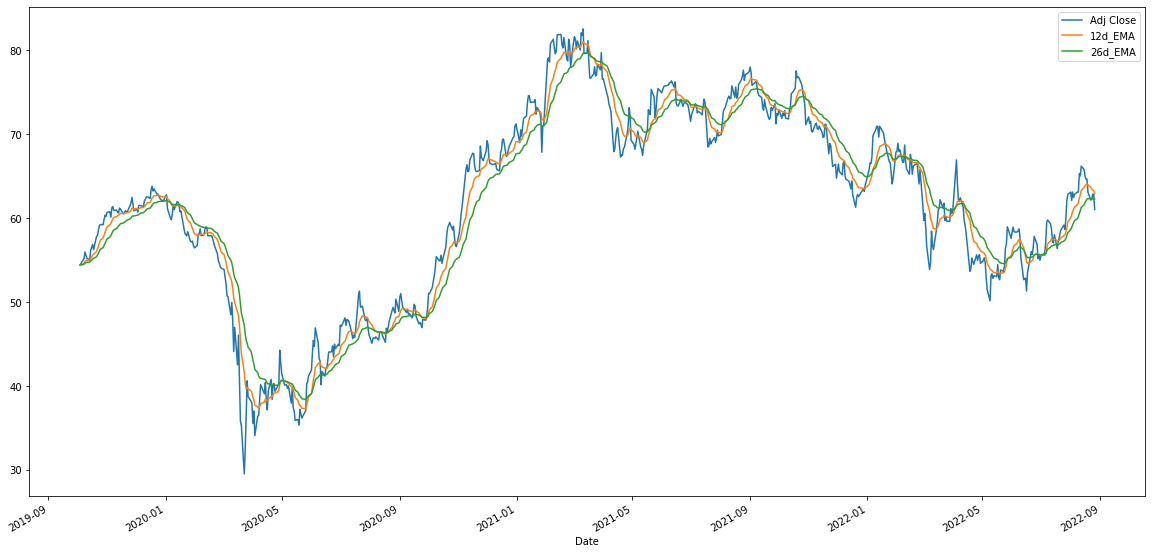

In [92]:
data['12d_EMA'] = data['Adj Close'].ewm(span=12, adjust=False).mean()
data['26d_EMA'] = data['Adj Close'].ewm(span=26, adjust=False).mean()

data[['Adj Close','12d_EMA','26d_EMA']].plot(figsize=(20,10))
plt.show()

In [93]:
data['macd'] = data['12d_EMA'] - data['26d_EMA'] 

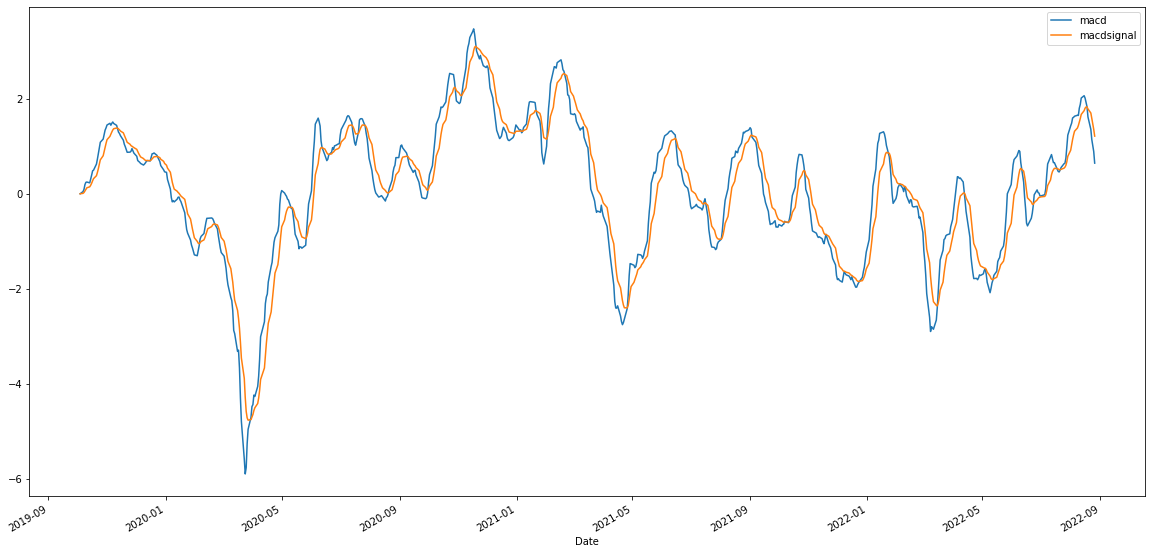

In [94]:
data['macdsignal'] = data.macd.ewm(span=9, adjust=False).mean()

data[['macd','macdsignal']].plot(figsize=(20,10))
plt.show()

#### Bollinger Bands

In [95]:
MA = data['Adj Close'].rolling(window=20).mean()
SD = data['Adj Close'].rolling(window=20).std()
data['UpperBB'] = MA + (2 * SD) 
data['LowerBB'] = MA - (2 * SD)

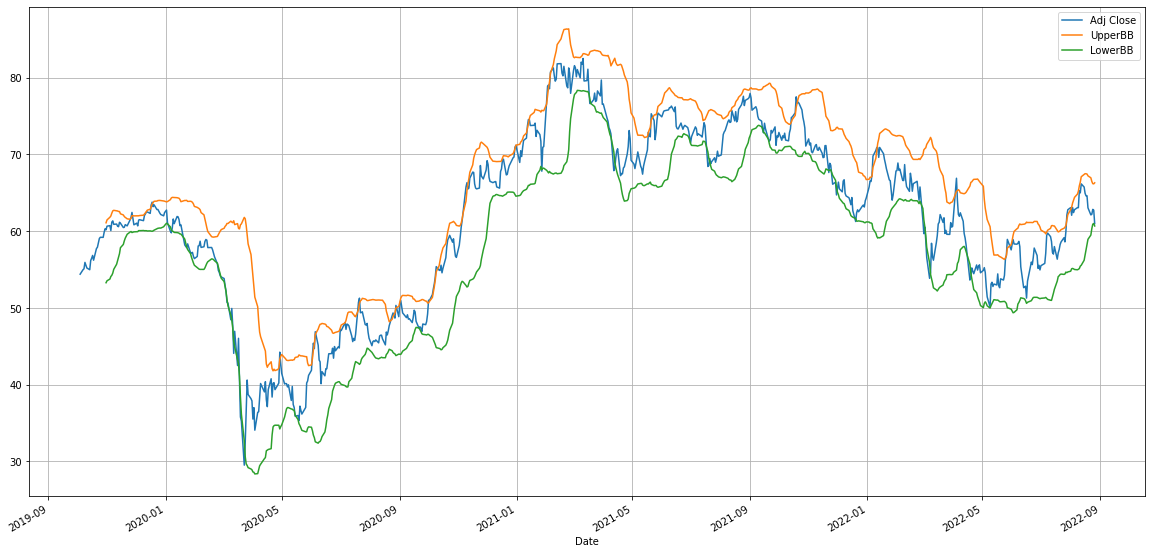

In [96]:
pd.concat([data['Adj Close'],data["UpperBB"],data["LowerBB"]],axis=1).plot(figsize=(20,10),grid=True);


#### Generating buy and sell signals

In [60]:
data['Direction'] = np.where((data['macd'] > data['macdsignal']) & 
                                      (data['Adj Close'] > data['UpperBB']), 1, 
                                     np.where((data['macd'] < data['macdsignal']) & 
                                               (data['Adj Close'] < data['LowerBB']),-1,0))



data['Direction']

Date
2019-09-20    0
2019-09-23    0
2019-09-24    0
2019-09-25    0
2019-09-26    0
             ..
2022-08-23    0
2022-08-24    0
2022-08-25    0
2022-08-26    0
2022-08-29    0
Name: Direction, Length: 730, dtype: int32

In [61]:
data["Direction"].value_counts()

 0    658
 1     41
-1     31
Name: Direction, dtype: int64

### Model building

In [62]:
from sklearn.model_selection import train_test_split


In [63]:
ICICI_final = data[['Adj Close','10daymovingavg', '20daymovingavg', 'std10', 'std20', 'rsi5', 'rsi14', 'Direction']]


In [64]:
X = ICICI_final.drop(['Direction'], axis=1)
y = ICICI_final['Direction']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1,stratify=ICICI_final['Direction'])


In [66]:
Train_icici = pd.concat([X_train,y_train], axis=1)
Test_icici = pd.concat([X_test,y_test], axis=1)


In [67]:
Train_icici['Direction'].value_counts()


 0    460
 1     29
-1     22
Name: Direction, dtype: int64

In [68]:
Test_icici['Direction'].value_counts()


 0    198
 1     12
-1      9
Name: Direction, dtype: int64

In [69]:
col_train=list(Train_icici)
col_test=list(Test_icici)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

Train_icici = pd.DataFrame(imputer.fit_transform(Train_icici))
Test_icici = pd.DataFrame(imputer.fit_transform(Test_icici))

Train_icici.columns=col_train
Test_icici.columns=col_test

Train_icici.head()

,Adj Close,10daymovingavg,20daymovingavg,std10,std20,rsi5,rsi14,Direction
0,328.164062,345.726926,326.959828,8.529729,23.258422,33.460246,46.976662,0.0
1,410.229828,430.107016,583.478610,13.056237,17.535025,29.120403,54.753710,0.0
2,379.356049,385.530814,373.998987,10.048598,14.110744,41.384696,53.821260,0.0
3,377.720703,356.510443,356.133820,13.377076,11.496349,79.687562,62.399548,0.0
4,480.798492,475.337360,467.832002,8.353513,17.716100,63.648107,62.764573,0.0


In [70]:
X_train = Train_icici.drop(['Direction'], axis=1)
y_train = Train_icici['Direction']

X_test = Test_icici.drop(['Direction'], axis=1)
y_test = Test_icici['Direction']

###  Model 1 -Cart model

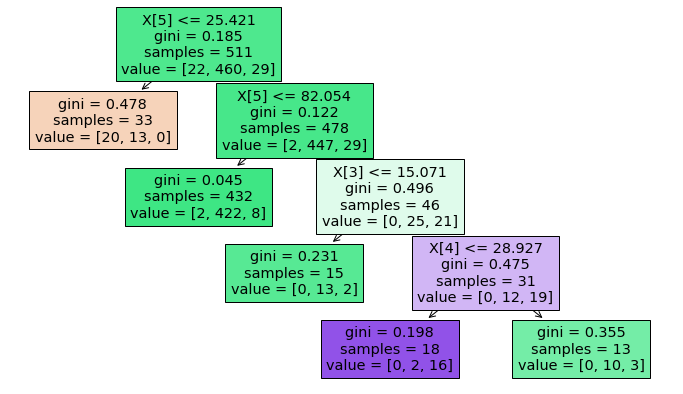

In [75]:
from sklearn import tree
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

clf = tree.DecisionTreeClassifier(max_leaf_nodes = 5)
plt.figure(figsize=(12,7))
tree.plot_tree(clf.fit(X_train, y_train),filled=True)
plt.show()

In [76]:
clf = clf.fit(X_train, y_train)


In [77]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

model_score_train = clf.score(X_train, y_train)
model_score_test = clf.score(X_test, y_test)

In [78]:
print(metrics.classification_report(y_train,y_pred_train,digits=3))
print(metrics.classification_report(y_test,y_pred_test,digits=3))

              precision    recall  f1-score   support

        -1.0      0.606     0.909     0.727        22
         0.0      0.967     0.967     0.967       460
         1.0      0.889     0.552     0.681        29

    accuracy                          0.941       511
   macro avg      0.821     0.809     0.792       511
weighted avg      0.947     0.941     0.941       511

              precision    recall  f1-score   support

        -1.0      0.562     1.000     0.720         9
         0.0      0.954     0.939     0.947       198
         1.0      0.375     0.250     0.300        12

    accuracy                          0.904       219
   macro avg      0.630     0.730     0.656       219
weighted avg      0.906     0.904     0.902       219



### Model 2 -  Random forest

In [80]:
from sklearn.ensemble import RandomForestClassifier
clfRF=RandomForestClassifier(n_estimators=100, max_leaf_nodes = 5)

In [81]:
clfRF.fit(X_train,y_train)


RandomForestClassifier(max_leaf_nodes=5)

In [82]:
y_pred_train = clfRF.predict(X_train)
y_pred_test = clfRF.predict(X_test)

RFmodel_score_train = clfRF.score(X_train, y_train)
RFmodel_score_test = clfRF.score(X_test, y_test)

In [97]:
print(metrics.classification_report(y_train,y_pred_train,digits=3))
print(metrics.classification_report(y_test,y_pred_test,digits=3));

              precision    recall  f1-score   support

        -1.0      1.000     0.636     0.778        22
         0.0      0.926     1.000     0.961       460
         1.0      0.000     0.000     0.000        29

    accuracy                          0.928       511
   macro avg      0.642     0.545     0.580       511
weighted avg      0.876     0.928     0.899       511

              precision    recall  f1-score   support

        -1.0      1.000     0.111     0.200         9
         0.0      0.908     1.000     0.952       198
         1.0      0.000     0.000     0.000        12

    accuracy                          0.909       219
   macro avg      0.636     0.370     0.384       219
weighted avg      0.862     0.909     0.869       219



C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero